# From Loops to Vectorization: Refactoring Sam’s Self‑Organizing Map


This notebook walks through **why and how** I refactored Sam’s original `kohonen.py`
implementation of a Self‑Organizing Map (SOM) into the vectorised **`MiniSam`** version.

Highlights:

1. **Revisit the baseline and highlight key enhancement for code efficiency** – inspect code efficiency bottlenecks and improvements.
2. **Code best structured for team collaboration and productionisation** 
3. **Run miniSam**
4. **Approach to production**



## Baseline — Sam’s original implementation

### Sam's code inefficiency bottlenecks and recommendation

This table below highlights efficiency issues ranked most to least critical based on my observation and how it is improved in MiniSam version.

| Area | Original | Recommendations | Where you can see it in miniSam |
|------|----------|---------|---------|
| **Loop structure** | Triple-nested Python loops | Replaces inner two loops with vectorised NumPy operations; only a single loop over iterations remains | train_random has just one for t in range(num_iteration): and then the broadcasted update self._weight += alpha_t * theta * (v - self._weight) |
| **Weight update** | weights[x, y] += … writes one float at a time inside the innermost loop. | Uses a single array-wide assignment so the entire map is updated in one C-level call | train_random and train_batch |
| **Distance / kernel computation** | Re-computes Euclidean distance and Gaussian kernel for every neuron, every sample, every iteration. | Pre-computes squared grid distances once and creates the kernel with vectorised math | Grid built in constructor (xs, ys = np.meshgrid…, _coords = …) ; distance helper *_sq_grid_dist* |
| **BMU search hand-off** | Finds the BMU with np.argmin, but then falls back to Python loops for neighbourhood propagation | Keeps everything in NumPy: BMU via argmin, neighbourhood mask applied to the whole map in one broadcasted expression. | winner implementation with dist2 = np.sum((self._weight - v)**2, axis=2) and np.argmin(dist2) |
| **Vectorisation & parallelism** | Heavy work in Python | All arithmetic is inside NumPy expressions, which automatically use multi-core BLAS | Any of the broadcasted math lines, e.g. theta = self._kernel(self._sq_grid_dist(i, j), sigma_t)[..., None] in train_random |
| **Memory allocations** | Creates many tiny temporaries like (weights – v)**2, thrashing the allocator and cache. | Fewer, larger array expressions reused across iterations; drastically lowers allocation churn. | Re-use of _coords and direct in-place weight add in train_random |
| **Batch-mode option** | Online-only update; can’t amortise calculations across samples | Adds train_batch that handles one global update per epoch, exploiting matrix ops for large datasets. | train_batch method and its (num, den) accumulation |
| **Hard-coded constants** | Learning rate (α₀) and radius (σ₀) are literals; changing them means editing code. | Exposes them as constructor parameters (plus random seed) for easy configuration and hyper-parameter sweeps. | Constructor signature and assignments in __init__ |
| **Input validation** | No checks—bad shapes or NaNs crash deep inside loops after wasting compute. | _validate_data catches errors early, preventing needless iterations and easing debugging.| _validate_data helper |


### 2. Code best structured for team collaboration and productionisation
1. The original Sam code is not production-ready as it does not follow software engineering best pratice - fails most key criteria for production: performance, observability, configurability, testing, and modular API design. Below are some of the reasons.

- Performance & scalability: Triple-nested Python loops make runtime grow cubically
- API design & reusability: Provides one hard-wired function; weights live only inside that call and vanish afterwards—no way to reuse or load a trained model.
- Input validation & error handling: Accepts any array; shape mismatches crash deep inside loops after wasting CPU
- Packaging & versioning: Stand-alone script; can’t be pip install-ed or version-pinned.
- Code style / PEP 8 compliance: Mixed camelCase/snake_case (σ0, α0), bare single-letter variables (vt, di); >80-char lines; no linting.
- Testing: no unit tests.
- Extensibility: Gaussian kernel and exponential decay are hard-wired inside inner loops; any change requires rewriting the core function. 

2. The original Sam code is hard for other developers to work on together:
- API: One all-in-one function, teammates can’t reuse a trained map, build unit tests around smaller pieces, or extend the code without diving into the full body.
- Modularity & separation of concerns: Everything—data generation, training loops, image saving—is interwoven in one script. 
- Documentation & naming: No doc-strings; single-letter names (σ0, vt, di); minimal comments.
- Configurable parameters: Learning rate and neighborhood radius are hard-coded literals.
- Unit-test: No test suite.



### 4. Run miniSam

Follow instruction from my github repo: https://github.com/jenny2202/miniSam

### 4. Approach to production

To turn the model from a research script into a production-ready component, I'd build an end-to-end MLOps pipeline around the model. Assume the client uses AWS and the model code is refactored into a python package already.

- Data prep: Create an automated pipeline for data collection, cleaning, feature engineering, and splitting data into training, validation, and test sets. Depends on the volume of data, data frequency, and purpose of model used, SageMaker Processing step, AWS Glue ETL or EMR is employed to read data from datalake S3 then do ETL. S3 can also be used as stage intermediate data in partitioned Parquet. Engineered features to be saved into Amazon SageMaker Feature Store for online/offline access.

- Model Training and Validation: I'd wrap MiniSam's training in a SageMaker training job. The Bayesian hyper parameter tuning (σ, learning rate, map size) is often heavy so considering to run parallel jobs on small spot instances with early stopping. MLflow for lineage.

- Deployment: After a successful run, register the artefact in the Model Registry. A CDK-defined CodePipeline promotes the approved version to either real-time endpoint or batch transformation for overnight dataset scoring. Roll out with blue/green variants, monitor error rate via CloudWatch, and auto-rollback on alarms.

- Monitoring & Maintenance: Stream data-quality and inference metrics (latency, error rate, feature drift, prediction drift) from the SageMaker endpoint or Batch Transform job into CloudWatch. Each night pull those CloudWatch metrics into Amazon QuickSight to keep a near-real-time dashboard for analysts and business stakeholders. Configure CloudWatch Alarms on drift or SLA thresholds. When an alarm fires, publish to an SNS topic. Automated retraining trigger by subscribing an AWS Step Functions workflow (or Lambda) to that SNS topic; the workflow launches the SageMaker Pipeline that performs data prep ➜ training ➜ evaluation ➜ deployment, then resets the alarm state.

- Explainability & Compliance: For each inference, return coordinates of BMU plus the Euclidean distance. Enable S3 Object Lock on training data buckets.


Below is high-level architecture of my approach:

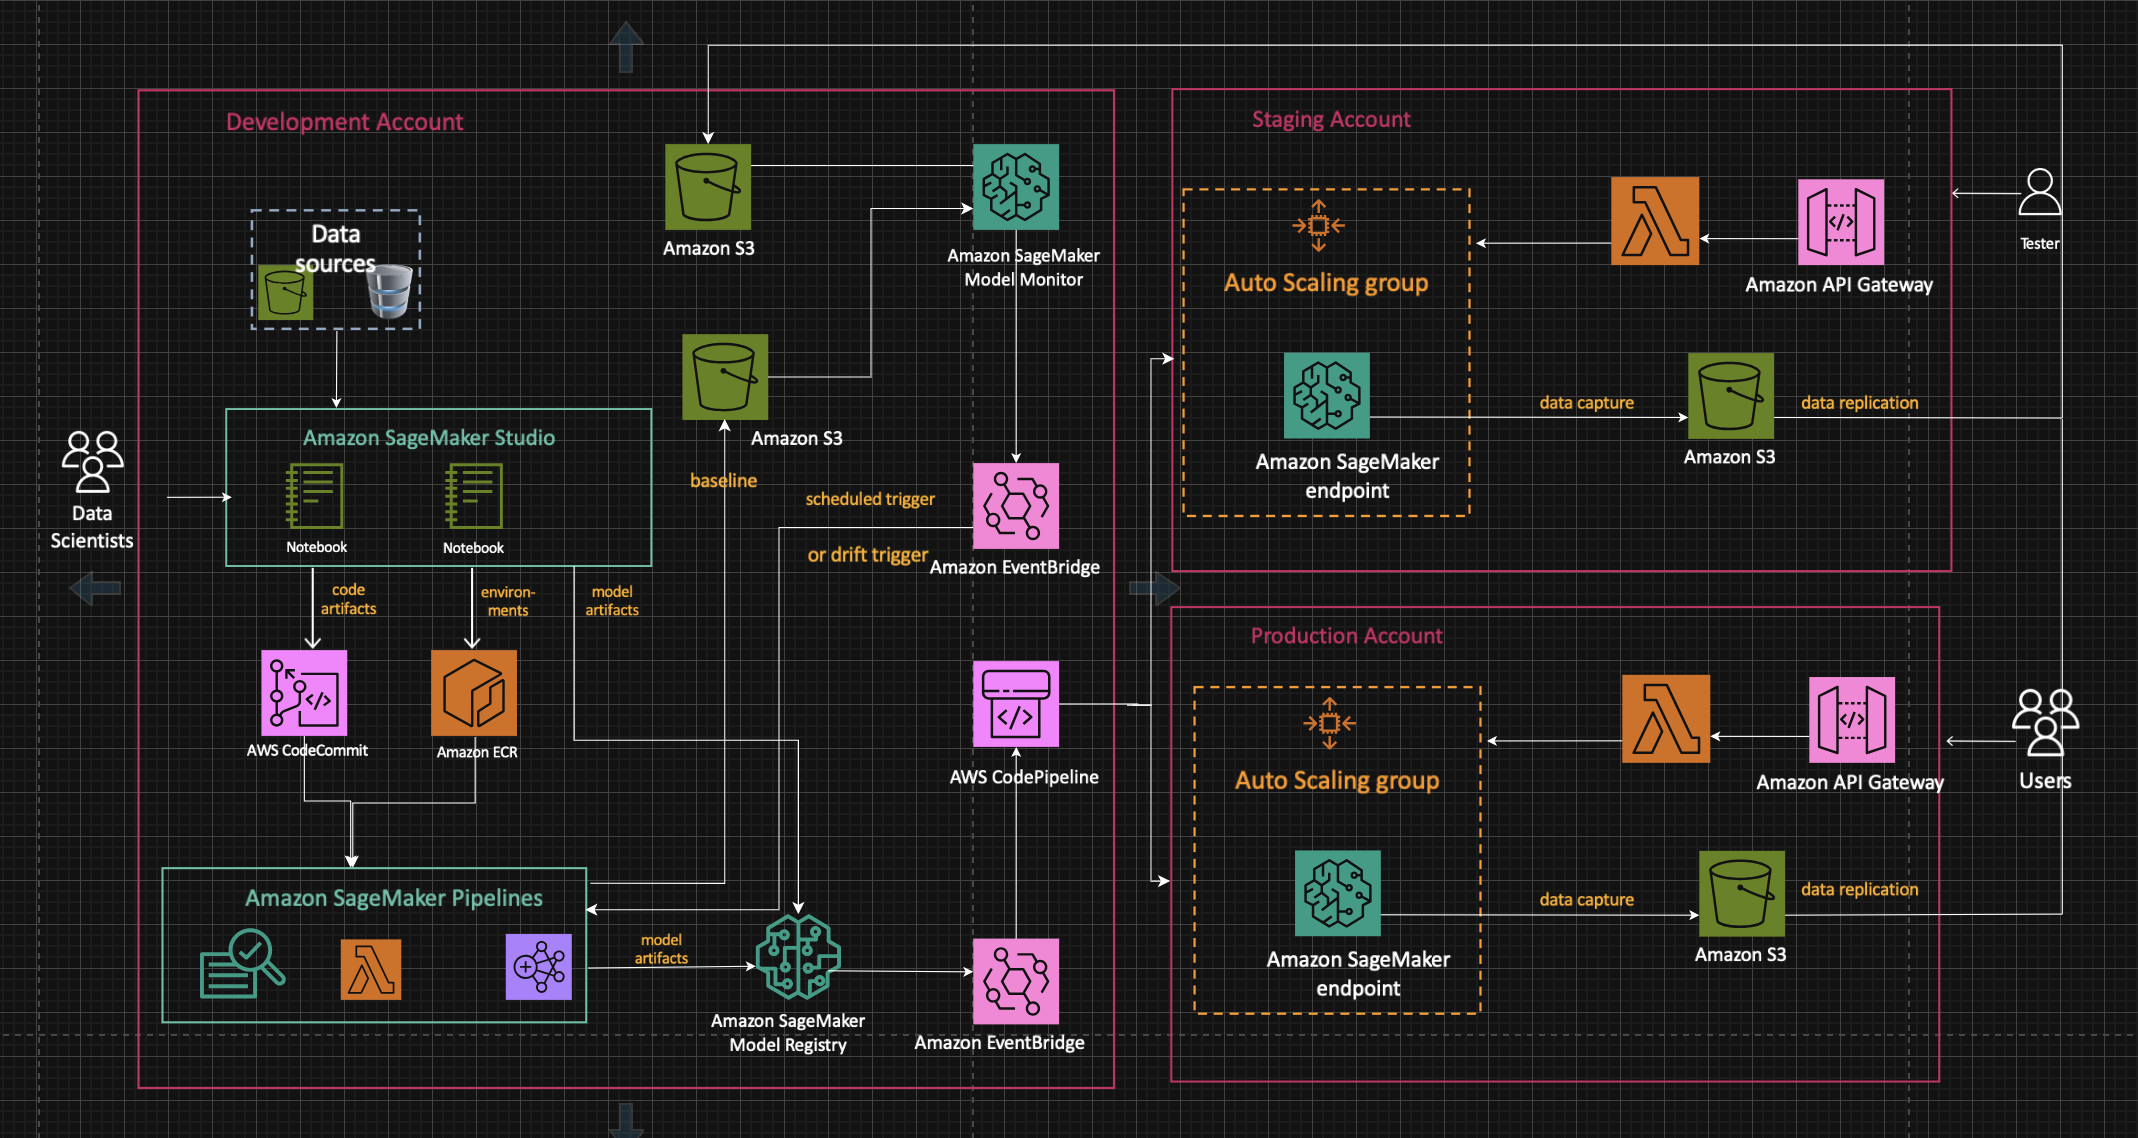
